In [3]:
import math
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [7]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data      = data
        self.grad      = 0.0
        self._backward = lambda: None
        self._prev     = set(_children)
        self._op       = _op
        self.label     = label

    def __repr__(self):
        return f"Value.data={self.data}"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def backward():
            self.grad  += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = backward
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def backward():
            self.grad  += other.data * out.grad
            other.grad += self.data  * out.grad

        out._backward = backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float for now"
        out = Value(self.data**other, (self,), f'**{other}')
        def backward():
            self.grad += other * self.data**(other-1) * out.grad
        out._backward = backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def tanh(self):
        t   = (math.exp(2.0*self.data)-1.0)/(math.exp(2.0*self.data)+1.0)
        out = Value(t, (self,), "tanh")
        def backward():
            self.grad += (1.0 - tanh(out.data)**2) * out.grad

        out._backward = backward
        return out

    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')
        def backward():
            self.grad += out.data * out.grad
        
        out._backward = backward
        return out

    def backward(self):
        self.grad = 1.0
        topo      = []
        visited   = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        for node in reversed(topo):
            node._backward()

In [45]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s: data %.2f | grad: %.2f}" % (n.label, n.data, n.grad ), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [6]:
a = Value(69)
1 + a

Value.data=70

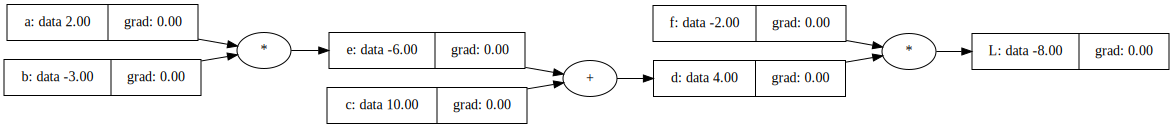

In [46]:
draw_dot(L)

In [ ]:
class Neuron:
    class __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    class __call__(self, x):
        act = sum(wi*xi for wi, xi in zip(self.w, x), self.b)
        out = act.tanh()
        return out